We worked taking help from the following notebook: https://colab.research.google.com/github/ohmeow/ohmeow_website/blob/master/_notebooks/2020-05-23-text-generation-with-blurr.ipynb



# Text Generation with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new text generation capabilities to train, evaluate, and deploy a BART summarization model.

- toc: false 
- badges: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, huggingface, blurr, text generation]
- image: images/articles/blurr-logo-small.png
- hide: false
- search_exclude: false
- show_tags: true

In [ ]:
# only run this cell if you are in collab
!pip install ohmeow-blurr
!pip install nlp

     |████████████████████████████████| 194kB 6.1MB/s 
     |████████████████████████████████| 675kB 16.3MB/s 
     |████████████████████████████████| 3.8MB 23.8MB/s 
     |████████████████████████████████| 1.1MB 37.1MB/s 
     |████████████████████████████████| 890kB 56.6MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=1f82b8114b6e5f78edadff25ae20bac8242be44d5a23a6d98e2d5c1397d41616
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8be5c340492160f9185ad84ef93bbe19108120decf779d36b6672d63d98f8181
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses
     |████████████████████████████████| 860kB 2.7MB/s 
     |████████████████████████████████| 63.8MB 48kB/s 
  Found existing installation: pyarrow 0.14.1

In [ ]:
import nlp
import pandas as pd
from fastai2.text.all import *
from transformers import *
import torch

from blurr.data.all import *
from blurr.modeling.all import *

## Data Preparation

We're going to use to use the new [nlp](https://github.com/huggingface/nlp) library from huggingface to grab your raw data.  This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model.  The best part being everything comes down to you in JSON!  This makes it a breeze to get up and running quickly!

In [ ]:
# raw_data = nlp.load_dataset('cnn_dailymail')
# raw_data.keys()

dict_keys(['test', 'train', 'validation'])

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [ ]:
# df = pd.DataFrame(raw_data['train'])
# df.head()

,article,highlights
0,"(CNN) -- A blowout preventer that may hold important forensic evidence as to why it failed, triggering the world's largest accidental oil spill, has been brought to the surface of the Gulf and placed on a vessel, officials said Saturday night. The device ""was taken into custody by the U.S. Department of Justice as evidence in its ongoing investigation into the incident,"" BP said. The blowout preventer was lifted to the surface at 8:53 p.m. (9:53 p.m. ET). Adm. Thad Allen, the government's national incident commander, said the huge blowout preventer ""is considered evidentiary material."" The...",NEW: The failed blowout preventer is brought to the surface .\nA new blowout preventer has been placed on the capped well .\nBP will continue work on its Gulf relief well .
1,"(CNN) -- A controversial photography exhibit called ""In the Playroom"" depicts young children reenacting tragic and violent historical events, including the September 11 attacks and the abuse of inmates at Iraq's infamous Abu Ghraib prison. The artist, Jonathan Hobin, says his work is an attempt to reflect on modern events that affect children and prompt dialogue about ""issues in our world."" But the photos have also drawn criticism from those who say Hobin's use of artistic license involving children crosses an ethical boundary. ""Some of it is appropriate,"" said psychiatrist Alvin Poussaint...","Exhibit ""In the Playroom"" depicts young children re-enacting violent events .\nPhotographer Jonathan Hobin says it reflects on modern events that affect children .\nHe says the exhibit is supposed to prompt dialogue about ""issues in our world""\nThe photos have drawn criticism from those who say it crosses an ethical line ."
2,"(CNN)Wintry weather is a relative thing. The Northeast is on alert -- urging drivers to stay off roads -- as the fourth storm in three weeks drops snow that in Boston has exceeded 45 inches in February alone. It takes a fraction of that to get residents in the South into emergency mode. Sometimes, it doesn't even have to snow -- just the possibility of wintry weather is enough for a partial shutdown. ""Wintry precipitation possible"" early this week, the National Weather Service in Atlanta said. The Weather Service issued a winter storm watch for northern Georgia, warning of potential snow a...",Winter storm watch in effect for parts of the South .\nJust a little snow or ice can be enough to cause havoc .
3,"(CNN) -- U.S. Sgt. Bowe Bergdahl -- a former captive, a survivor and a hometown hero to many in Hailey, Idaho -- is being accused by some of his fellow soldiers of deserting his post. This charge of treason will be proven or dismissed in the coming weeks and months. But whether it is true or not, and whether he faces official military charges, he has already been sentenced to life to be haunted by his captivity -- and if the allegations are true, his choices. Survivors of the Hanoi Hilton, POWs during Vietnam such as Sen. John McCain and Medal of Honor winner Adm. James Stockdale, endured ...","Bowe Bergdahl a ""hometown hero"" in Hailey, Idaho, and a ""deserter"" to some soldiers .\nO'Shea: He learned Pashtun; building rapport with captors is critical to survival as a hostage .\nHe says Bergdahl probably wondered each day if this would be his last .\nTo break vow to fellow soldiers is terrible: If he indeed deserted, that will haunt him, too ."
4,"(CNN) -- Rafael Nadal continued his domination on clay as he crushed compatriot Guillermo Garcia-Lopez 6-1, 6-2 in the second round of the Barcelona Open. The Spaniard carved out 15 break points during the match, polishing off Garcia-Lopez in just over 80 minutes. It was Nadal's 30th straight victory at the event, where he has won six of the last seven titles at the Real Club de Tennis. Nadal has started the season in ominous form. After battling back from a serious knee injury, the world number two won his first title in ten months last week after finally beating riv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/COVID-19/dataset

/content/drive/My Drive/COVID-19/dataset


In [ ]:
df = torch.load("/content/drive/My Drive/COVID-19/dataset/LATEST/train.pt")

In [ ]:
df.head()

,Abstract,Body
34616,"We present three data driven model-types for COVID-19 with a minimal number of parameters to provide insights into the spread of the disease that may be used for developing policy responses. The first is exponential growth, widely studied in analysis of early-time data. The second is a self-exciting branching process model which includes a delay in transmission and recovery. It allows for meaningful fit to early time stochastic data. The third is the well-known Susceptible-Infected-Resistant (SIR) model and its cousin, SEIR, with an ""Exposed"" component. All three models are related quantit...","The world is in the midst of an ongoing pandemic, caused by the emergence of a novel coronavirus. Pharmaceutical interventions such as vaccination and anti-viral drugs are not currently available. In the short run, addressing the COVID-19 outbreak will depend critically on the successful implementation of public health measures including social distancing, workplace modifications, disease surveillance, contact tracing, isolation, and quarantine. \n\n On March 16th, Imperial College London released a report predicting dire consequences if the US and UK did not swiftly take action. In respo..."
10388,Un bref descriptif des attitudes et représentations d'une patientèle de psychiatrie libérale parisienne relative à la pandémie SARS-CoV-2. Les données recueillies auprès de nos patients laissent entendre qu'ils ont accueilli la mesure de confinement de façon positive. Sa fin a été l'occasion d'un sursaut d'angoisse pour beaucoup. L'image du Covid-19 et celle du corps de l'autre ont eu tendance à se confondre. Une certaine perplexité relative aux mesures préventives a été observée.,"Notre cabinet parisien a continué de fonctionner pendant toute la durée du confinement. La moitié des patients se sont absentés durant cette période et les autres ont maintenu le contact, principalement par téléconsultation. Le nombre de nouveaux patients a été très réduit. Nous décrivons ici les attitudes de nos patients devant l'épidémie ainsi que les représentations qu'ils ont pu développer de cette dernière dans le contexte du confinement. \n\n Il a été généralement bien observé, la plupart des patients disant le tolérer bien et profitant selon L'attitude générale, pour les adultes act..."
27709,"Endophytes are the group of microorganisms that reside to internal and healthy tissues without causing negative symptoms to their host plant. Endophytes are extremely diverse and range from fungi, bacteria and actinomycetes. Development of drug resistance to pathogenic forms of bacteria, fungi and other microbes, emergence of lethal viruses, the perpetuating epidemics in developing and under developing countries, and multifold fungal infection, enhancement in human population globally, all shows our inability to overcome these biomedical problems. In addition to this, we are also unable to...","Originally, the term endophyte was introduced by de Bary ( 1866 ) and was assigned to all those microbes that reside inside the living healthy tissues of the plants. Later, this term was expanded as fungi and bacteria including actinomycetes, which spend the whole or at least a part of their life cycle colonizing inter-or intra-cellularly, inside the healthy living tissue of the host plant, typically causing no apparent symptoms of disease. Many workers defi ne the endophytes in different ways, but Bacon and White ( 2000 ) gave a conclusive and widely accepted defi nition of endophyte as '..."
29449,"Studies of proteinaceous cysteine protease inhibitors originated with the discovery of cystatins in the 1960s. Since that time, a rich and fascinating world of proteins that control and regulate a multitude of important physiological processes, ranging from the basics of protein turnover to development and brain function, has been uncovered. Failures in such important and complex systems inevitably lead to pathologies. Many threatening diseases such as cancer

In [ ]:
ls

fine_tuning_bert_attempt.ipynb  main_df.pt     models/  train.pt
LATEST/                         main_df_v2.pt  test.pt


We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"

hf_arch, hf_tokenizer, hf_config, hf_model = \
    BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, BartTokenizer, HF_MODELS.BartForConditionalGeneration)

hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('bart',
 transformers.tokenization_bart.BartTokenizer,
 transformers.configuration_bart.BartConfig,
 transformers.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice we're specifying `trg_max_length` to constrain our decoder inputs to 250 so that our input/predicted summaries will be padded to 250 rather than the default which is whatever you are using for your encoder inputs (e.g., the text you want summarized).

In [ ]:
blocks = ( 
    HF_TextBlock(hf_arch, hf_tokenizer), 
    HF_TextBlock(hf_arch, hf_tokenizer, task=ForConditionalGenerationTask(), trg_max_length=512)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('Body'), 
                   get_y=ColReader('Abstract'), 
                   splitter=RandomSubsetSplitter(0.05, 0.01))

In [ ]:
dls = dblock.dataloaders(df, bs=4)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [ ]:
b = dls.one_batch()
len(b), b[0][0].shape, b[1].shape

(2, torch.Size([4, 512]), torch.Size([4, 250]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target
0,"The intracellular environment is extremely crowded. Estimates show that the concentration of biological macromolecules (proteins, nucleic acids, ribonucleoproteins, polysaccharides, etc.) inside cells is in the range of 80-400 mg/mL [1] [2] [3]. This corresponds to a volume occupancy of 5%-40% [4] and creates a crowded medium, with considerably restricted amounts of free water [1, [5] [6] [7] [8] [9]. Such natural intracellular media, being filled with billions of protein molecules [10] and a myriad of DNA, RNA, and polysaccharide molecules are known as ""crowded"" rather than ""concentrated"" environments, as, in general, no individual macromolecular species may be present at high concentration [7, 11]. Obviously, the average spacing between macromolecules in such crowded milieu can be much smaller than the size of the macromolecules themselves [12]. Furthermore, the volume occupied by solutes is unavailable to other molecules because two molecules cannot be in the same place at the same time. As a result, any reactions that depend on available volume can be affected by macromolecular crowding effects [5, 13], and the thermodynamic consequences of the unavailable volume are called excluded volume effects [5, 14]. In other words, the fact that two molecules cannot occupy the same space in solution, and that steric hindrance or impediment of a macromolecule is expected to exclude other molecules from its neighborhood give rise to the excluded volume phenomenon [15]. In solutions with increasing concentrations of such particles, the number of ways that can be used to place added molecules is progressively limited since the volume of solution available to the new molecules is progressively restricted to the part of space from which they are not excluded [15]. The consequence of this phenomenon is decreased randomness of the particle distribution in the concentrated solutions leading to the noticeable decrease in the entropy of the crowded solution. Such entropy decrease increases the free energy of the solute and thereby produces an increase in the thermodynamic activity of solute, and therefore is expected to affect various processes determined by the activity [15]. Importantly for this review, the mentioned excluded volume effects do not only influence the thermodynamic activity of the concentrated solute itself but also affects any other solute present in the solution at low concentrations [15].","The intracellular environment represents an extremely crowded milieu, with a limited amount of free water and an almost complete lack of unoccupied space. Obviously, slightly salted aqueous solutions containing low concentrations of a biomolecule of interest are too simplistic to mimic the ""real life"" situation, where the biomolecule of interest scrambles and wades through the tightly packed crowd. In laboratory practice, such macromolecular crowding is typically mimicked by concentrated solutions of various polymers that serve as model ""crowding agents"". Studies under these conditions revealed that macromolecular crowding might affect protein structure, folding, shape, conformational stability, binding of small molecules, enzymatic activity, protein-protein interactions, protein-nucleic acid interactions, and pathological aggregation. The goal of this review is to systematically analyze currently available experimental data on the variety of effects of OPEN ACCESS Int. J. Mol. Sci. 2014, 15 23091 macromolecular crowding on a protein molecule. The review covers more than 320 papers and therefore represents one of the most comprehensive compendia of the current knowledge in this exciting area."
1,"Foodborne pathogens (FBPs) cause foodborne diseases (FBDs) either directly (by infectious agents) or indirectly (by toxic metabolites, i.e., bacterial toxins and mycotoxins; EMAN, 2015; Martinovic et al., 2016) and can have devastating health and economic consequences in both developed and developing countries (Pires et a

## Training

We'll prepare our BART model for training by wrapping it in blurr's `HF_TextGenerationModelWrapper` model object.  This class will handle ensuring all our inputs get translated into the proper arguments needed by a huggingface conditional generation model.  We'll also use a custom model splitter that will allow us to apply discriminative learning rates over the various layers in our huggingface model.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with BART only thus far (if you try any other conditional generation transformer models they may or may not work ... if you do, lmk either way)

In [ ]:
model = HF_TextGenerationModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(ignore_index=hf_tokenizer.pad_token_id),
                cbs=[HF_BaseModelCallback],
                splitter=partial(text_gen_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(b), len(b[0]), b[0][0].shape, len(b[1]), b[1].shape, len(preds), preds[0].shape

(2,
 4,
 torch.Size([4, 512]),
 4,
 torch.Size([4, 250]),
 2,
 torch.Size([4, 250, 50264]))

Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=6.309573450380412e-07)

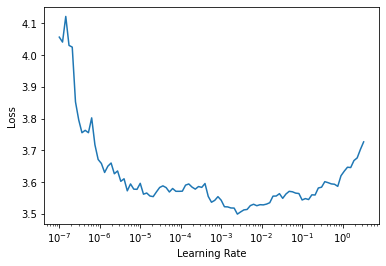

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,time
0,3.523116,3.488940,01:01


And now we can look at the "greedy decoded" predictions ...

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target,prediction
0,"Linear plasmids have been found in the cytoplasm of yeast species from nine genera, including Kluyveromyces, Debaryomyces, Saccharomyces, Saccharomycopsis, Wingea, and\n\nPichia (1, 2). The overall genetic organization of all yeast cytoplasmic linear plasmids is identical with that of the most studied plasmids, pGKL1 (also termed K1) and pGKL2 (also termed K2), from the yeast Kluyveromyces lactis, where their presence is associated with the killer phenotype (3). Killer strains contain 50 to 100 copies of each of the two linear plasmids per cell (4). The pGKL1 and pGKL2 plasmids have compact and extremely AT-rich genomes sized 8874 and 13447 bp, respectively, and carry terminal inverted repeats with proteins covalently attached to their 5' ends (5-7).\n\nThe smaller plasmid, pGKL1, contains four open reading frames (ORFs): two of them (K1ORF2 and K1ORF4) encode precursors of killer toxin subunits (8-10); K1ORF3 is involved in an immunity phenotype in an unknown manner (11), and K1ORF1 codes for the pGKL1 plasmid-specific DNA polymerase and a terminal protein (12,13). Eleven ORFs have been reported in the larger pGKL2 plasmid, which provides vital functions for pGKL1/pGKL2 maintenance in host cell (14). Some functions have been attributed to more than half of the proteins encoded by the ORFs carried by the pGKL2 plasmid. K2ORF2 codes for a pGKL2-specific DNA polymerase and a terminal protein (5,15). K2ORF3 codes for a virus-like mRNA capping enzyme. A purified K2Orf3 protein (K2Orf3p) displayed 5'triphosphatase (TPase) and RNA-guanylyltransferase (GTase) activities; however the predicted RNA cap (guanine-N 7 )-methyltransferase (MTase) activity, which is the third crucial activity of conventional mRNA capping complexes, was not detected (","Linear plasmids with almost identical compact genetic organization have been found in the cytoplasm of yeast species from nine genera. We employed pGKL1,2 plasmids from Kluyveromyces lactis as a model to investigate the previously unstudied transcriptome of yeast cytoplasmic linear plasmids. We performed 5' and 3' RACE analysis of all the pGKL1,2 mRNAs and found them not 3' polyadenylated and containing mostly uncapped 5' poly(A) leaders that are not complementary to the plasmid DNA. The degree of 5' capping and/or 5' polyadenylation is specific to each gene and is controlled by the corresponding promoter regions. We refined the description of the pGKL1,2 promoters and found new alternative promoters of several genes. We also provide evidence that K2ORF3 encodes an mRNA cap guanine-N 7 -methyltransferase and that 5' capped pGKL1,2 transcripts contain N 7 -methylated caps. Translation of pGKL1,2 transcripts is enhanced in lsm1Δ and pab1Δ",Linear.asmids. terminal identical genetic genomes organization. been found in the cytoplasm of yeast species from nine genera. Ki
1,"The accumulation of unfolded protein in the endoplasmic reticulum (ER) results in ER stress that triggers the unfolded protein response (UPR), a complex signal transduction cascade that orchestrates adaptation to ER stress or induces apoptosis if ER stress remains unmitigated [1] [2] [3] [4] [5] [6]. In mammalian cells, the UPR is mediated by three classes of membrane-associated sensor transducers including inositol-requiring transmembrane kinase/endonuclease (IRE1), protein kinase RNA (PKR)-like ER kinase (PERK), and activating transcription factor 6 (ATF6) [2, 3]. In contrast to animals, the UPR in yeast is controlled by only the IRE1p-mediated signaling pathway, which triggers the expression of over 5% genes mainly encoding chaperones and ER-associated protein degradation components in the genome [7]. The IRE1 lumenal domain at the N-terminus serves as a UPR sensor domain and the C-terminal cytoplasmic portion encompassing serine/threonine protein kinase and endoribonuclease domains functions as an effector domain [3]. Upon sensing ER stress, IRE1 dimerizes or oligomerizes in the plane of the ER mem

Even better though, blurr augments the fastai Learner with a `generate_text` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

HAVE TO TEST WITH COVID ARTICLES


In [ ]:
test_article = """
A PROMISING CORONAVIRUS vaccine candidate cleared a key hurdle this week, when Moderna Therapeutics entered phase two of clinical trials. The move signals that the company’s mRNA vaccine has passed its initial safety checks and has met an important milestone in bringing this drug closer to the public and commercial markets.

After almost five months of global deaths and economic shutdowns wrought by the COVID-19 pandemic, people are anxiously awaiting a glimmer of hope for a return to normal routines. This partly explains the recent frenzy over results from Moderna and its frontrunner candidate, which moved from the company’s lab in Cambridge, Massachusetts, to human trials in a record-setting 63 days.

On May 18, the biotech company had announced preliminary findings that healthy subjects had responded to its mRNA vaccine by producing “neutralizing antibodies.” Antibodies are the key sentinels made by the immune system to prevent infection by the coronavirus. Experts were quick to point out that the results applied to only eight people out of 45 in the trial, which is being conducted by the U.S. National Institute of Allergy and Infectious Diseases. The company has not released sufficient information to gauge whether the phase one subjects had protective immune responses, which is widely considered by immunologists to involve more than simply producing antibodies.

But the details that Moderna did present, paired with the latest announcement, suggest that the company may be on its way to achieving something unprecedented: licensing the first mRNA vaccine for human use.
"""

In [ ]:
outputs = learn.generate_text(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
Moderna Therapeutics entered phase two of clinical trials for its coronavirus vaccine. The move signals that the company’s mRNA vaccine has passed its initial safety checks.

=== Prediction 2 ===
Moderna Therapeutics entered phase two of clinical trials this week. The move signals that the company’s mRNA vaccine has passed its initial safety checks.

=== Prediction 3 ===
Moderna Therapeutics entered phase two of clinical trials. The move signals that the company’s mRNA vaccine has passed its initial safety checks.



What about inference?  Easy!

In [ ]:
learn.generate_text(test_article)

['Moderna Therapeutics entered phase two of clinical trials for its coronavirus vaccine. The move signals that the company’s mRNA vaccine has passed its initial safety checks.']

In [ ]:
learn.export(fname='/content/drive/My Drive/COVID-19/dataset/models/covid-19.pkl.pth')

In [ ]:
learn = load_learner("/content/drive/My Drive/COVID-19/dataset/models/covid-19.pkl")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'transformers.modeling_bart.BartForConditionalGeneration' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
learn.generate_text(test_article)

[" This week, Moderna Therapeutics entered phase two of clinical trials for its promising coronavirus vaccine candidate. The move signals that the company's mRNA vaccine has passed its initial safety checks and has met an important milestone in bringing this drug closer to the public and commercial markets."]

In [ ]:
inf_learn = load_learner(fname='covid-19.pkl.pth')
inf_learn.generate_text(test_article)

FileNotFoundError: ignored

## That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to text generation (e.g., sequence classification , token classification, and question/answering). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!